In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import datetime


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.executing_eagerly())
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
True


In [3]:
batch_size = 2
img_width = 512
img_height = 512

In [4]:
data_dir = "archive/tiff/"
print(os.listdir(data_dir))

['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [5]:
bmp = "archive/bmp/"
folders = os.listdir(bmp)
filenames =  [[],[],[],[],[],[]]
i=0
for folder in folders:
    images = os.listdir(bmp + folder)
    for image in images:
        filenames[i].append(str(bmp + folder + "/" + image))
    i += 1
test, test_labels, train, train_labels, val, val_labels = filenames

In [6]:
def read_filenames(filepath1, filepath2):
    pil_image1 =  tf.io.read_file(filepath1)
    image1 = tf.io.decode_bmp(pil_image1, channels=0)
    pil_image2 =  tf.io.read_file(filepath2)
    image2 = tf.io.decode_bmp(pil_image2, channels=0)
    return (image1,image2)

In [7]:
class DataReader():
    def __init__(self, filenames1, filenames2, batch_size):
        # filenames: list of files
        self.filenames1 = filenames1
        self.filenames2 = filenames2
        self.dataset = None
        print("{} filenames received".format(len(filenames1)))
        print("{} filenames received".format(len(filenames2)))
        self.batch_size = batch_size
        self.run()
        
    def read_filenames(self, filepath1, filepath2):
        pil_image1 =  tf.io.read_file(filepath1)
        image1 = tf.io.decode_bmp(pil_image1, channels=0)
        image1 = tf.image.resize(image1, [500,500])
        image1 = tf.image.pad_to_bounding_box(image1, 6, 6, img_height, img_width)
        image1 = tf.cast(image1, tf.float32)
        pil_image2 =  tf.io.read_file(filepath2)
        image2 = tf.io.decode_bmp(pil_image2, channels=0)
        image2 = tf.image.resize(image2, [500,500])
        image2 = tf.image.pad_to_bounding_box(image2, 6, 6, img_height, img_width)
        image2 = tf.cast(image2, tf.int32)
        return [image1,image2]

    def run(self):
        self.dataset = tf.data.Dataset.from_tensor_slices((self.filenames1, self.filenames2))
        self.dataset = self.dataset.shuffle(len(self.filenames1), reshuffle_each_iteration=True)
        self.dataset = self.dataset.map(self.read_filenames, num_parallel_calls=10)
        self.dataset = self.dataset.batch(self.batch_size)
#         self.dataset = self.dataset.prefetch(1)
        return self.dataset

In [8]:
test_data = DataReader(test, test_labels, batch_size)
# print(list(test_data.dataset.take(1).as_numpy_iterator())[0].shape)
# test_labels_data = DataReader(test_labels, batch_size)
train_data = DataReader(train,train_labels, batch_size)
# train_labels_data = DataReader(train_labels, batch_size)
val_data = DataReader(val,val_labels, batch_size)
# val_labels_data = DataReader(val_labels, batch_size)

49 filenames received
49 filenames received
1108 filenames received
1108 filenames received
14 filenames received
14 filenames received


## Show some images

In [9]:
# # Test data
# fig, axs = plt.subplots(3, 3)
# fig.set_figheight(10)
# fig.set_figwidth(10)
# x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
# print(x[0].shape)
# index = 0
# for i in range(3):
#     for j in range(3):
#         axs[i][j].imshow(x[0][index,:,:,:])
#         index += 1

In [10]:
# # Test Labels data
# fig, axs = plt.subplots(3, 3)
# fig.set_figheight(10)
# fig.set_figwidth(10)
# x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
# index = 0
# for i in range(3):
#     for j in range(3):
#         axs[i][j].imshow(x[index])
#         index += 1

## Inspection of the shape of our data

In [11]:
print("Input data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][0].shape))
print("Output data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][1].shape))

Input data = (2, 512, 512, 3)
Output data = (2, 512, 512, 1)


In [12]:
## Check to see that the data is one hot encoded

In [13]:
x = list(test_data.dataset.take(1).as_numpy_iterator())[0][1][1]
print(x.shape)
np.unique(x, return_counts=True)

(512, 512, 1)


(array([  0, 255]), array([243812,  18332], dtype=int64))

# Model Creation (Figure out how to set the final output: 2 classes or 1000x1000 ?)

In [14]:
from tensorflow.python.keras import callbacks, optimizers
from tensorflow.python.keras.models import Model, load_model, model_from_json
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv2DTranspose, Concatenate

inp = Input((img_width,img_height,3))
print(inp)
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
block_1_out = Activation('relu')(x)
x = MaxPooling2D()(block_1_out)
print("Block 1 : {}".format(x.shape))
# Block 2
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
block_2_out = Activation('relu')(x)
x = MaxPooling2D()(block_2_out)
print("Block 2 : {}".format(x.shape))
# Block 3
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
block_3_out = Activation('relu')(x)
x = MaxPooling2D()(block_3_out)
print("Block 3 : {}".format(x.shape))
# Block 4
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
block_4_out = Activation('relu')(x)

print("Block 4 : {}".format(x.shape))

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = BatchNormalization()(x)
x = Activation('relu')(x)
print(x)
print(block_3_out)
x = Concatenate()([x, block_3_out])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
print("Block 3 up : {}".format(x.shape))
# UP 3
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_2_out])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
print("Block 2 up : {}".format(x.shape))
# UP 4
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_1_out])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(x.shape)

Tensor("input_1:0", shape=(None, 512, 512, 3), dtype=float32)
Block 1 : (None, 256, 256, 64)
Block 2 : (None, 128, 128, 128)
Block 3 : (None, 64, 64, 256)
Block 4 : (None, 64, 64, 512)
Tensor("activation_10/Relu:0", shape=(None, 128, 128, 256), dtype=float32)
Tensor("activation_6/Relu:0", shape=(None, 128, 128, 256), dtype=float32)
Block 3 up : (None, 128, 128, 256)
Block 2 up : (None, 256, 256, 128)
(None, 512, 512, 1)


In [15]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
#     intersection = tf.cast(intersection, tf.int32)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [16]:
model = Model(inputs=inp, outputs=x)
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam,
              loss=dice_coef,
              metrics=[dice_coef_loss])

In [17]:
model.fit(train_data.dataset,
          verbose=1,
          epochs=1,
          validation_data = val_data.dataset,
         )

554/554 [==============================] - 1055s 2s/step - loss: 0.0685 - dice_coef_loss: 0.9315 - val_loss: 0.0046 - val_dice_coef_loss: 0.9954


In [22]:
# Compute Stats
out_pred = model(tuple(train_data.dataset.take(1))[0][0][:1]).numpy()
out_true = tuple(train_data.dataset.take(1))[0][1][:1]
print("Min = {}".format(np.min(out_pred)))
print("Max = {}".format(np.max(out_pred)))
print("Shape of output_pred = {}".format(np.shape(out_pred)))
print("Shape of output_true= {}".format(np.shape(out_true)))
print("Counts of output_pred = {}".format(np.unique(out_pred, return_counts=True)))
print("Counts of output_true= {}".format(np.unique(out_true, return_counts=True)))

ResourceExhaustedError: OOM when allocating tensor with shape[1,512,512,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [21]:
model.save('saved_models/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/my_model\assets


NameError: name 'model' is not defined

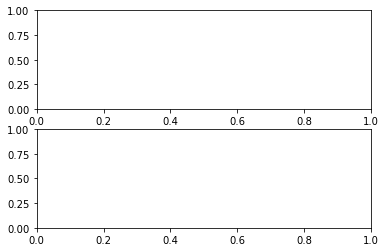

In [11]:
fig, axs = plt.subplots(2)
test_result = model.predict(tuple(train_data.dataset.take(1))[0][0][:1]).reshape((img_height,img_width))
axs[0].imshow(tuple(train_data.dataset.take(1))[0][0][1])
axs[1].imshow(test_result)
# tuple(train_data.dataset.take(1))[0][0][1].numpy()

In [9]:
loaded = tf.saved_model.load("saved_models/my_model")

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


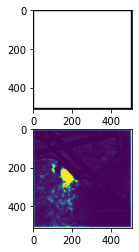

In [20]:
fig, axs = plt.subplots(2)
test_result = loaded(tuple(train_data.dataset.take(1))[0][0][:1]).numpy().reshape((img_height,img_width))
print(tuple(train_data.dataset.take(1))[0][0][1].shape)
axs[0].imshow(tuple(train_data.dataset.take(1))[0][0][1])
axs[1].imshow(test_result)

In [ ]:
np.unique((tuple(train_data.dataset.take(1))[0][1][:1]).numpy(), return_counts=True)